In [13]:
import numpyro
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, DiscreteHMCGibbs

from jax import numpy as jnp
from jax import random

import numpy as np
import pandas as pd
# import seaborn as sns
import arviz as az

# from dfply import *
from siuba import _
import siuba as s

import pickle

%run -i 'model_helpers.py'
%run -i 'models.py'
%run -i 'ic-compare.py'

In [3]:
df1 = load_query_avg_data_exp1() # see data_helpers.py
df1 = df1[~df1.querytype.str.contains('or')]
# df1 = df1[df1["condition"]!=2] # filter out "warm/snowy" as per paper
df1.head()


,ID,condition,querytype,querydetail,estimate
0,0,0,A,icy,0.503333
1,0,0,AandB,icy and frosty,0.616667
2,0,0,AandnotB,icy and not frosty,0.453333
3,0,0,AgB,icy given frosty,0.766667
4,0,0,AgnotB,icy given not frosty,0.340000


In [4]:
df2 = load_query_avg_data_exp2() # see data_helpers.py
df2 = df2[df2["condition"]!=2] # filter out "warm/snowy" as per paper
df2.head()


,ID,condition,querytype,querydetail,estimate
0,0,0,A,windy,0.733333
1,0,0,AandB,windy and cloudy,0.773333
2,0,0,AandnotB,windy and not cloudy,0.676667
3,0,0,AgB,windy given cloudy,0.816667
4,0,0,AgnotB,windy given not cloudy,0.600000


In [7]:
fits = dict()
fits["exp1"] = dict()
fits["exp2"] = dict()

fits["exp1"]["Relative Freq."] = pickle.load(open("local/exp1/az_data_rf.p", "rb"))
fits["exp1"]["Bayesian Sampler simple"] = pickle.load(open("local/exp1/az_data_bs_simple.p", "rb"))
fits["exp1"]["Bayesian Sampler complex"] = pickle.load(open("local/exp1/az_data_bs.p", "rb"))
fits["exp1"]["Bayesian Sampler simple hier."] = pickle.load(open("local/exp1/az_data_bs_mlm_simple.p", "rb"))
fits["exp1"]["Bayesian Sampler complex hier."] = pickle.load(open("local/exp1/az_data_bs_mlm.p", "rb"))
fits["exp1"]["PT+N complex"] = pickle.load(open("local/exp1/az_data_ptn.p", "rb"))
fits["exp1"]["PT+N simple"] = pickle.load(open("local/exp1/az_data_ptn_simple.p", "rb"))
fits["exp1"]["PT+N complex hier."] = pickle.load(open("local/exp1/az_data_ptn_mlm.p", "rb"))
fits["exp1"]["PT+N simple hier."] = pickle.load(open("local/exp1/az_data_ptn_mlm_simple.p", "rb"))
fits["exp1"]["Unrestricted BS hier."] = pickle.load(open("local/exp1/az_data_ptn_mlm_simplecond.p", "rb"))

fits["exp2"]["Relative Freq."] = pickle.load(open("local/exp2/az_data_rf.p", "rb"))
fits["exp2"]["Bayesian Sampler simple"] = pickle.load(open("local/exp2/az_data_bs_simple.p", "rb"))
fits["exp2"]["Bayesian Sampler complex"] = pickle.load(open("local/exp2/az_data_bs.p", "rb"))
fits["exp2"]["Bayesian Sampler simple hier."] = pickle.load(open("local/exp2/az_data_bs_mlm_simple.p", "rb"))
fits["exp2"]["Bayesian Sampler complex hier."] = pickle.load(open("local/exp2/az_data_bs_mlm.p", "rb"))
fits["exp2"]["PT+N complex"] = pickle.load(open("local/exp2/az_data_ptn.p", "rb"))
fits["exp2"]["PT+N simple"] = pickle.load(open("local/exp2/az_data_ptn_simple.p", "rb"))
fits["exp2"]["PT+N complex hier."] = pickle.load(open("local/exp2/az_data_ptn_mlm.p", "rb"))
fits["exp2"]["PT+N simple hier."] = pickle.load(open("local/exp2/az_data_ptn_mlm_simple.p", "rb"))
fits["exp2"]["Unrestricted BS hier."] = pickle.load(open("local/exp2/az_data_ptn_mlm_simplecond.p", "rb"))

In [26]:
loos = dict()
loos["exp1"] = dict()
loos["exp2"] = dict()

loos["exp1"]["Relative Freq."] = pickle.load(open("local/exp1/loo_rf.p", "rb"))
loos["exp1"]["Bayesian Sampler simple"] = pickle.load(open("local/exp1/loo_bs_simple.p", "rb"))
loos["exp1"]["Bayesian Sampler complex"] = pickle.load(open("local/exp1/loo_bs.p", "rb"))
loos["exp1"]["Bayesian Sampler simple hier."] = pickle.load(open("local/exp1/loo_bs_mlm_simple.p", "rb"))
loos["exp1"]["Bayesian Sampler complex hier."] = pickle.load(open("local/exp1/loo_bs_mlm.p", "rb"))
loos["exp1"]["PT+N complex"] = pickle.load(open("local/exp1/loo_ptn.p", "rb"))
loos["exp1"]["PT+N simple"] = pickle.load(open("local/exp1/loo_ptn_simple.p", "rb"))
loos["exp1"]["PT+N complex hier."] = pickle.load(open("local/exp1/loo_ptn_mlm.p", "rb"))
loos["exp1"]["PT+N simple hier."] = pickle.load(open("local/exp1/loo_ptn_mlm_simple.p", "rb"))
loos["exp1"]["Unrestricted BS hier."] = pickle.load(open("local/exp1/loo_ptn_mlm_simplecond.p", "rb"))

loos["exp2"]["Relative Freq."] = pickle.load(open("local/exp2/loo_rf.p", "rb"))
loos["exp2"]["Bayesian Sampler simple"] = pickle.load(open("local/exp2/loo_bs_simple.p", "rb"))
loos["exp2"]["Bayesian Sampler complex"] = pickle.load(open("local/exp2/loo_bs.p", "rb"))
loos["exp2"]["Bayesian Sampler simple hier."] = pickle.load(open("local/exp2/loo_bs_mlm_simple.p", "rb"))
loos["exp2"]["Bayesian Sampler complex hier."] = pickle.load(open("local/exp2/loo_bs_mlm.p", "rb"))
loos["exp2"]["PT+N complex"] = pickle.load(open("local/exp2/loo_ptn.p", "rb"))
loos["exp2"]["PT+N simple"] = pickle.load(open("local/exp2/loo_ptn_simple.p", "rb"))
loos["exp2"]["PT+N complex hier."] = pickle.load(open("local/exp2/loo_ptn_mlm.p", "rb"))
loos["exp2"]["PT+N simple hier."] = pickle.load(open("local/exp2/loo_ptn_mlm_simple.p", "rb"))
loos["exp2"]["Unrestricted BS hier."] = pickle.load(open("local/exp2/loo_ptn_mlm_simplecond.p", "rb"))

In [28]:
# exp1_model_comparison = az.compare(fits["exp1"], scale="deviance", ic="loo", method="BB-pseudo-BMA")
# exp2_model_comparison = az.compare(fits["exp2"], scale="deviance", ic="loo", method="BB-pseudo-BMA")

# exp1_model_comparison = exp1_model_comparison >> s.mutate(Experiment = "Exp. 1", model = exp1_model_comparison.index)
# exp2_model_comparison = exp2_model_comparison >> s.mutate(Experiment = "Exp. 2", model = exp2_model_comparison.index)

exp1_model_comparison = compare(loos["exp1"], method="BB-pseudo-BMA")
exp2_model_comparison = compare(loos["exp2"], method="BB-pseudo-BMA")

exp1_model_comparison = exp1_model_comparison >> s.mutate(Experiment = "Exp. 1", model = exp1_model_comparison.index)
exp2_model_comparison = exp2_model_comparison >> s.mutate(Experiment = "Exp. 2", model = exp2_model_comparison.index)




/opt/conda/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: paper-rmd/plot_compare.png


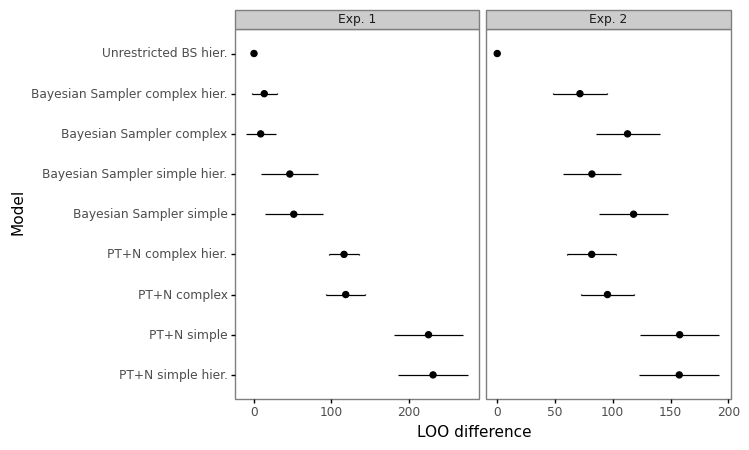

<ggplot: (8792574108916)>

In [30]:
from plotnine import *
import siuba as s
from siuba import _

model_comparison = exp1_model_comparison.append(exp2_model_comparison)

plt_compare = (
    model_comparison >>
    s.filter(_.model!="Relative Freq.") >>
    s.mutate(ul = _.d_loo + _.dse*2, ll = _.d_loo - _.dse*2) >>
    ggplot(aes(y="reorder(model, -d_loo)",  x= "d_loo", xmin="ll", xmax="ul")) +
    geom_point(size=2) +
    geom_errorbarh(height=.01, size=.5) +
    facet_wrap("Experiment", scales="free_x") +
    labs(x = "LOO difference", y = "Model") +
    theme_bw() +
    theme(panel_grid = element_blank())
)
plt_compare.save(filename="paper-rmd/plot_compare.png")
plt_compare

In [31]:
model_comparison

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale,Experiment,model
Unrestricted BS hier.,0,1080.108109,297.935267,0.000000,8.222427e-01,50.196874,0.000000,True,log,Exp. 1,Unrestricted BS hier.
Bayesian Sampler complex,1,1071.474529,280.841991,8.633580,1.688862e-01,44.826868,9.676237,True,log,Exp. 1,Bayesian Sampler complex
Bayesian Sampler complex hier.,2,1066.833562,291.124125,13.274548,8.871075e-03,47.979818,8.127625,True,log,Exp. 1,Bayesian Sampler complex hier.
Bayesian Sampler simple hier.,3,1033.791032,264.957562,46.317078,1.323216e-08,47.470805,18.392887,True,log,Exp. 1,Bayesian Sampler simple hier.
Bayesian Sampler simple,4,1028.686748,270.704797,51.421362,1.643046e-08,44.214146,18.831316,True,log,Exp. 1,Bayesian Sampler simple
PT+N complex hier.,5,963.652729,298.339700,116.455380,2.217033e-35,45.356981,9.572544,True,log,Exp. 1,PT+N complex hier.
PT+N complex,6,961.478101,264.366424,118.630009,7.220583e-31,40.354714,12.579995,True,log,Exp. 1,PT+N complex
PT+N simple,7,854.415490,254.533103,225.692620,1.289842e-71,36.408282,22.305739,True,log,Exp. 1,PT+N simple
PT+N simple hier.,8,848.544395,265.404488,231.563715,3.059821e-75,46.677080,22.606636,True,log,Exp. 1,PT+N simple hier.
Relative Freq.,9,639.407259,299.334691,440.700850,1.640945e-162,43.362805,27.184243,True,log,Exp. 1,Relative Freq.


# Model parameters

## Experiment 1

In [21]:
model1 = fits["exp1"]["Unrestricted BS hier."]

az.summary(
    model1,
    var_names = ["d_base_sd", "d_delta_sd"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base_sd,1.429,0.187,1.087,1.780,0.004,0.003,2106.0,3882.0,1.0
d_delta_sd,1.067,0.282,0.592,1.591,0.005,0.003,3225.0,4745.0,1.0


In [22]:
model1.posterior["d_prime_pop"] = model1.posterior.d_base_pop + np.exp(model1.posterior.d_delta_pop)
# az.plot_posterior(model1, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

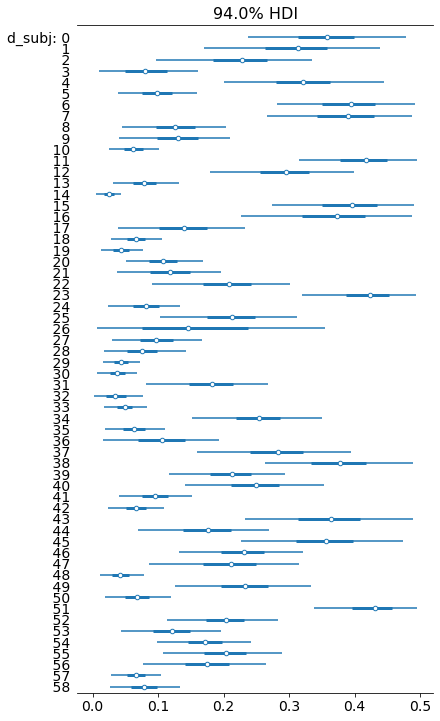

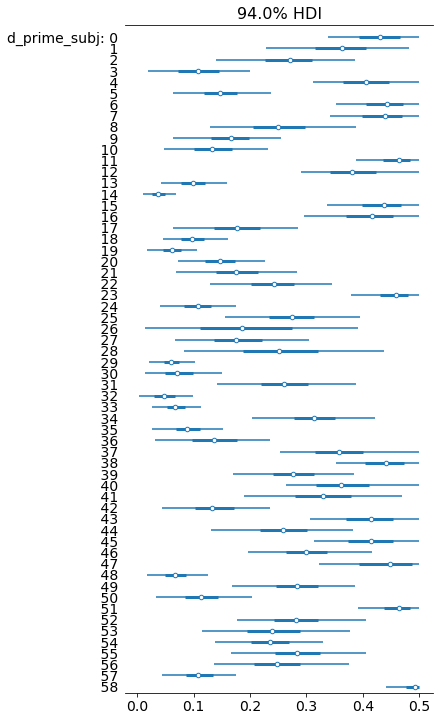

In [23]:
# plot them all
az.plot_forest(data=model1, var_names=["d_subj"], combined=True)
az.plot_forest(data=model1, var_names=["d_prime_subj"], combined=True)

In [11]:
# how many individual participant estimates are over .33 ?
print(np.sum(model1.posterior.stack(draws=("chain", "draw")).d_subj.mean(axis=1) > 1/3))
print(np.sum(model1.posterior.stack(draws=("chain", "draw")).d_prime_subj.mean(axis=1) > 1/3))

<xarray.DataArray 'd_subj' ()>
array(11)
<xarray.DataArray 'd_prime_subj' ()>
array(18)


## Experiment 2

In [24]:
model2 = fits["exp2"]["Unrestricted BS hier."]

az.summary(
    model2,
    var_names = ["d_base_sd", "d_delta_sd"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base_sd,0.808,0.102,0.624,0.999,0.002,0.002,1975.0,3513.0,1.0
d_delta_sd,0.205,0.128,0.019,0.436,0.002,0.001,3740.0,4948.0,1.0


/opt/conda/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: paper-rmd/plot_params.png


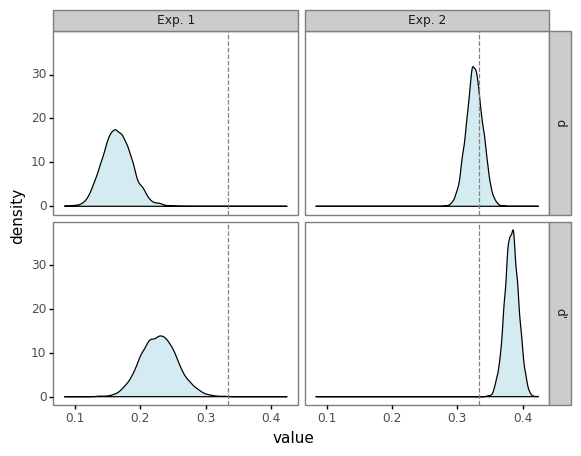

<ggplot: (8746545763172)>

In [28]:
model2 = fits["exp2"]["Unrestricted BS hier."]
model2.posterior["d_prime_pop"] = model2.posterior.d_base_pop + np.exp(model2.posterior.d_delta_pop)
# az.plot_posterior(model2, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2)
param_posterior1 = model1.posterior.stack(draws=("chain", "draw"))[["d_base_pop", "d_prime_pop"]].to_dataframe()
param_posterior2 = model2.posterior.stack(draws=("chain", "draw"))[["d_base_pop", "d_prime_pop"]].to_dataframe()

param_posterior1 = param_posterior1 >> s.mutate(Experiment = "Exp. 1")
param_posterior2 = param_posterior2 >> s.mutate(Experiment = "Exp. 2")

plt_params = (
    param_posterior1.append(param_posterior2) >> 
    # s.rename(d = _.d_base_pop, d = _.d_prime_pop) >>
    s.gather("term", "value", _.d_base_pop, _.d_prime_pop) >>
    s.mutate(term = s.if_else(_.term=="d_base_pop", "d", "d'")) >>
    s.mutate(value = _.value.transform(lambda x: np.exp(-np.logaddexp(0, -x))/2)) >>
    ggplot(aes(x="value")) +
    geom_density(fill="lightblue", alpha=.5) +
    geom_vline(xintercept=.3333, linetype="dashed", color="grey") +
    facet_grid("term ~ Experiment") +
    theme_bw() +
    theme(aspect_ratio=.75) +
    theme(panel_grid = element_blank())
)
plt_params.save(filename="paper-rmd/plot_params.png")
plt_params

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

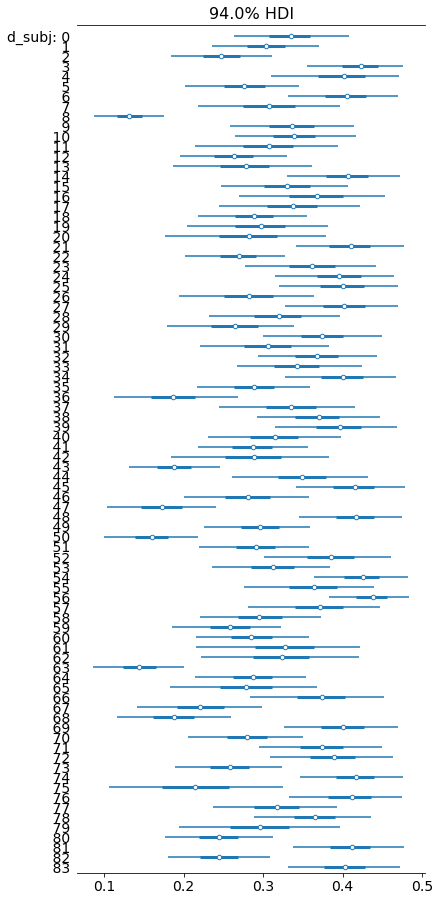

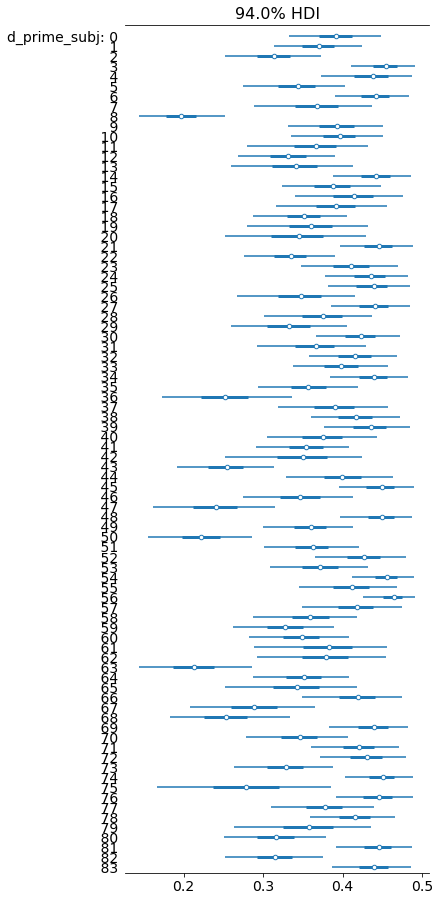

In [13]:
# plot them all
az.plot_forest(data=model2, var_names=["d_subj"], combined=True)
az.plot_forest(data=model2, var_names=["d_prime_subj"], combined=True)

Bayesian Sampler conditional response corr =  0.7186
Bayesian Sampler conditional query-level corr 0.9244


<AxesSubplot:xlabel='preds', ylabel='estimate'>

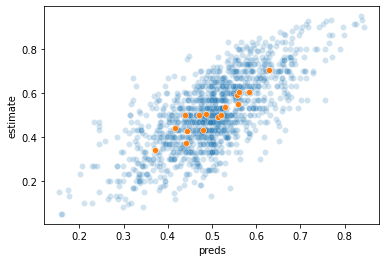

In [14]:
# zoom in on conditional trials
import seaborn as sns
d = df2
d["preds"] = fits["exp2"]["Unrestricted BS hier."].posterior_predictive.mean(dim=['chain', 'draw']).yhat
d = d[d.querytype.transform(is_cond).astype("bool")]
trial_df = (d
                .groupby(["querytype", "querydetail"])
                .agg({"preds":"mean", "estimate":"mean"}).reset_index()
               )

print("Bayesian Sampler conditional response corr = ", np.round(np.corrcoef(d.estimate, d.preds)[0,1],4))
sns.scatterplot(x = d.preds, y = d.estimate, alpha=.2)
print("Bayesian Sampler conditional query-level corr", np.round(np.corrcoef(trial_df.estimate, trial_df.preds)[0,1],4))
sns.scatterplot(x = trial_df.preds, y = trial_df.estimate)

PT+N conditional response corr =  0.6702
PT+N conditional query-level corr 0.8541


<AxesSubplot:xlabel='preds', ylabel='estimate'>

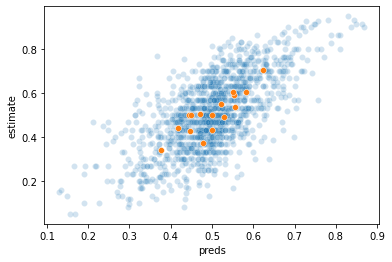

In [15]:
d = df2
d["preds"] = fits["exp2"]["PT+N complex hier."].posterior_predictive.mean(dim=['chain', 'draw']).yhat
d = d[d.querytype.transform(is_cond).astype("bool")]

trial_df = (d
                .groupby(["querytype", "querydetail"])
                .agg({"preds":"mean", "estimate":"mean"}).reset_index()
               )

print("PT+N conditional response corr = ", np.round(np.corrcoef(d.estimate, d.preds)[0,1],4))
sns.scatterplot(x = d.preds, y = d.estimate, alpha=.2)
print("PT+N conditional query-level corr", np.round(np.corrcoef(trial_df.estimate, trial_df.preds)[0,1],4))
sns.scatterplot(x = trial_df.preds, y = trial_df.estimate)

# Create fit summary table

In [16]:
def response_level_r(orig_data, model):
    
    d = orig_data
    d["preds"] = model.posterior_predictive.mean(dim=['chain', 'draw']).yhat
    
    return np.round(np.corrcoef(d.estimate, d.preds)[0,1],3)
    
def trial_level_r(orig_data, model):
    
    d = orig_data
    d["preds"] = model.posterior_predictive.mean(dim=['chain', 'draw']).yhat

    trial_df = (d
                .groupby(["querytype", "querydetail"])
                .agg({"preds":"mean", "estimate":"mean"})
               )
    
    return np.round(np.corrcoef(trial_df.estimate, trial_df.preds)[0,1],3)


    
print(response_level_r(df1, fits["exp1"]["Unrestricted BS hier."]))
print(trial_level_r(df1, fits["exp1"]["Unrestricted BS hier."]))

0.884
0.964


In [17]:
exp1_corrs = pd.DataFrame({
    "model": fits["exp1"].keys(),
    "resp_r": [response_level_r(df1, fits["exp1"][k]) for k in fits["exp1"].keys()],
    "trial_r": [trial_level_r(df1, fits["exp1"][k]) for k in fits["exp1"].keys()],
    "Experiment": "Exp. 1"
     }
)

exp2_corrs = pd.DataFrame({
    "model": fits["exp2"].keys(),
    "resp_r": [response_level_r(df2, fits["exp2"][k]) for k in fits["exp1"].keys()],
    "trial_r": [trial_level_r(df2, fits["exp2"][k]) for k in fits["exp1"].keys()],
    "Experiment": "Exp. 2"
     }
)

full_model_compare = s.left_join(model_comparison, exp1_corrs.append(exp2_corrs), by=["model","Experiment"])

In [18]:
table_output = (
    full_model_compare >> 
    s.mutate(loo = np.round(_.loo,1), penalty = np.round(_.p_loo, 1)) >>
    s.select(_.Experiment, _.model, _.loo, _.penalty, _.resp_r, _.trial_r)
)

table_output

,Experiment,model,loo,penalty,resp_r,trial_r
0,Exp. 1,Unrestricted BS hier.,-2163.2,296.4,0.884,0.964
1,Exp. 1,Bayesian Sampler complex,-2134.4,285.1,0.883,0.961
2,Exp. 1,Bayesian Sampler complex hier.,-2131.9,292.0,0.883,0.960
3,Exp. 1,Bayesian Sampler simple hier.,-2053.9,271.8,0.874,0.953
4,Exp. 1,Bayesian Sampler simple,-2051.3,273.7,0.874,0.952
5,Exp. 1,PT+N complex hier.,-1927.4,298.3,0.867,0.946
6,Exp. 1,PT+N complex,-1922.8,264.5,0.864,0.941
7,Exp. 1,PT+N simple,-1708.8,254.5,0.838,0.918
8,Exp. 1,PT+N simple hier.,-1697.1,265.4,0.839,0.919
9,Exp. 1,Relative Freq.,-1266.2,305.7,0.820,0.875


In [19]:
with open('paper/model-comparison-table.tex', 'w') as tf:
     tf.write(table_output.to_latex())

need to reconfigure this table, ideally with experiment as a horizontal grouping. not sure how to do that tho

In [20]:
with open('paper-rmd/model-comparison-table.csv', 'w') as tf:
     tf.write(table_output.to_csv())